In [1]:
#import relevant libraries
import os
from scipy import stats

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dabest
import NLCLIMB
import NLMATH
import itertools
from datetime import datetime
date = datetime.today().strftime('%Y%m%d')
from statistics import mean

import dabest_jck
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objects import Layout

#NOTE: SUPPRESSES WARNINGS!

import warnings


warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


In [2]:
#initial file processing
computer1 = "C:\\Users\\User"
computer2 = "C:\\Users\\lnico"
filedir = "\\ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Data Compilation\\Falling_New\\"
openPath = computer1 + filedir
files = os.listdir(openPath)

#identifying genotypes
responder = "ACR"
respondercsv = responder + ".csv"
wt = "w1118"

In [3]:
lst=[]


for file_no in os.listdir(openPath): 
    if respondercsv in file_no and "w1118" not in file_no :   #wt > acr files
        f = os.path.join(openPath, file_no)
        dfe=pd.read_csv(f)
        exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
        driver = file_no.split(" ")[0]
        lst.append(driver)

In [4]:
def timeabove(dfexpt, dfwt):

    #time above mean line
    heightwt = NLMATH.maxheight(dfwt, "wt")
    avgmaxheight_wt = heightwt['Max height wt'].mean() 

    ce = NLMATH.timespentabovemeanline(dfexpt, avgmaxheight_wt, "Expt")
    ce2 = NLMATH.timespentabovemeanline(dfwt, avgmaxheight_wt, "WT")

    timehang = pd.DataFrame()
    timehang = pd.concat([ce, ce2], axis = 0)
    timehang['genre'] = timehang['ExperimentState'] + " " + timehang['Type']
    
    
    timeabovemeanline = dabest.load(data=timehang, x=["ExperimentState","Type"], y= "Time", delta2 = True, 
                               experiment="Type",experiment_label = ["WT", "Expt"], x1_level = ["Dark","Full"], 
                               paired = "sequential", id_col = "index")
    lst= []
    lst.append(timeabovemeanline.mean_diff.delta_delta.difference)
    
    return lst


def falls(dfe_dark, dfe_full, dfw_dark, dfw_full):
    
    filtered = (dfe_dark.filter(regex="Fall.*").sum(axis=0))/1
    filtered2 = (dfe_full.filter(regex="Fall.*").sum(axis=0))/1
    filtered3 = (dfw_dark.filter(regex="Fall.*").sum(axis=0))/1
    filtered4 = (dfw_full.filter(regex="Fall.*").sum(axis=0))/1

    awt=pd.DataFrame()
    awt['Falls']=filtered
    awt['ExperimentState'] = "Dark"

    awt2=pd.DataFrame()
    awt2['Falls']=filtered2
    awt2['ExperimentState'] = "Full"


    awt2b = pd.concat([awt, awt2]).reset_index()
    awt2b["Type"] = "Expt"

    awt3=pd.DataFrame()
    awt3['Falls']=filtered3
    awt3['ExperimentState'] = "Dark"

    awt4=pd.DataFrame()
    awt4['Falls']=filtered4
    awt4['ExperimentState'] = "Full"
    awt4b = pd.concat([awt3, awt4]).reset_index()
    awt4b["Type"] = "WT"
    

    awt5=pd.DataFrame()
    awt5 = pd.concat([awt2b, awt4b])
    
    return awt5

def manyfall (dfexpt, dfwt):
    
    dfe_dark = dfexpt[(dfexpt['ExperimentState']== 'Dark')] 
    dfe_full = dfexpt[(dfexpt['ExperimentState']== 'Full')] 
    dfw_dark = dfwt[(dfwt['ExperimentState']== 'Dark')] 
    dfw_full = dfwt[(dfwt['ExperimentState']== 'Full')] 
    awt5 = falls(dfe_dark, dfe_full, dfw_dark, dfw_full)

    awt5['genre'] = awt5['ExperimentState'] + " " + awt5['Type']
    awt5['value'] = 0
    awt5.loc[(awt5['Falls'] >0), ['value']] = 1

  
    deltaplots = dabest.load(data=awt5, x=["ExperimentState","Type"], y="Falls", delta2 = True, experiment="Type", experiment_label = ["WT", "Expt"], x1_level = ["Dark","Full"], paired = "sequential", id_col = "index")
    
    lst= []
    lst.append(deltaplots.mean_diff.delta_delta.difference)
    return lst


# run if new data

In [8]:
def deltaversion(df_sp, genotype, metric):

    df9 = pd.DataFrame()
    dfsp_db = df_sp[(df_sp['ExperimentState'] != "Recovery") ]
    dfsp_db2 = dabest_jck.load(data = dfsp_db, x = ['ExperimentState', 'ExperimentState'], paired = "baseline", id_col="index", y = metric, delta2 = True, experiment = "Type", x1_level = ["Dark", "Full"], experiment_label = ["WT","Expt"] ) #if delta2 = dabest; deltaG = dabest_jck
    dfstatstest = dfsp_db2.delta_g.statistical_tests
        
    if dfstatstest['control'][0].split(" ")[1] == "WT" and dfstatstest['control'][1].split(" ")[1] == "Expt":
        dfdiff = pd.DataFrame({"MBON": genotype, "WT": round(dfstatstest['difference'][0],3), "Expt": round(dfstatstest['difference'][1],3), "delta_g": round(dfsp_db2.delta_g.delta_delta.difference,3)}, index = [genotype])


    return (dfdiff)

def ospeed(dfwt, dfexpt):
    
    df_se = NLMATH.velodabest(dfexpt, "Expt", "Velocity")
    df_sw = NLMATH.velodabest(dfwt, "WT", "Velocity")
    
    fgt6=pd.DataFrame()
    fgt6 = pd.concat([df_se, df_sw]).reset_index(drop=False)
    fgt6['genre'] = fgt6['ExperimentState'] + " " + fgt6['Type']

    return fgt6

def timetype(dfwt, dfexpt):
    
    heightwt = NLMATH.maxheight(dfwt, "wt")
    avgmaxheight_wt = heightwt['Max height wt'].mean() 

    ce = NLMATH.timespentabovemeanline(dfexpt, avgmaxheight_wt, "Expt")
    ce2 = NLMATH.timespentabovemeanline(dfwt, avgmaxheight_wt, "WT")

    timehang = pd.DataFrame()
    timehang = pd.concat([ce, ce2], axis = 0)
    timehang['genre'] = timehang['ExperimentState'] + " " + timehang['Type']
    
    return timehang

def separation(dfexpt, dfwt, phrase):
        
    dfe_dark = dfexpt[(dfexpt['ExperimentState']== 'Dark')] 
    dfe_full = dfexpt[(dfexpt['ExperimentState']== 'Full')] 
    dfw_dark = dfwt[(dfwt['ExperimentState']== 'Dark')] 
    dfw_full = dfwt[(dfwt['ExperimentState']== 'Full')] 
    
    filterword = phrase + ".*"
    
    expts = [dfe_dark, dfe_full, dfw_dark, dfw_full]
    results = []
    for e in expts:
        filtereddf = e.filter(regex=filterword)
    
        match phrase:
            case "Y":
                result = getattr(filtereddf, "mean")(axis=0)
            case "Fall":
                result = getattr(filtereddf, "sum")(axis=0)/1
                
        results.append(result)
        
    awt=pd.DataFrame()
    awt[phrase]= results[0]
    awt['ExperimentState'] = "Dark"

    awt2=pd.DataFrame()
    awt2[phrase]=results[1]
    awt2['ExperimentState'] = "Full"

    awt2b = pd.concat([awt, awt2]).reset_index()
    awt2b["Type"] = "Expt"


    awt3=pd.DataFrame()
    awt3[phrase]=results[2]
    awt3['ExperimentState'] = "Dark"

    awt4=pd.DataFrame()
    awt4[phrase]=results[3]
    awt4['ExperimentState'] = "Full"
    awt4b = pd.concat([awt3, awt4]).reset_index()
    awt4b["Type"] = "WT"
    

    awt5=pd.DataFrame()
    awt5 = pd.concat([awt2b, awt4b])
    
    return awt5

def fallingocc(dfexpt, dfwt):
    
    awt5 = separation(dfexpt, dfwt, "Fall")
    awt5['genre'] = awt5['ExperimentState'] + " " + awt5['Type']
    awt5['value'] = 0
    awt5.loc[(awt5['Fall'] >0), ['value']] = 1

    return awt5

def totalheight(dfexpt, dfwt):
    
    awt5 = separation(dfexpt, dfwt, "Y")
    awt5['genre'] = awt5['ExperimentState'] + " " + awt5['Type']

    return awt5

def countval(data, value):  #value = pause events
    count = 0
    timelst =[]
    for key, group in itertools.groupby(data, lambda x: x == value ):
        groupAsList = list(group)
        if( key == True ):
            count += 1
            timed = 0.2*len(groupAsList)
            timelst.append(timed)

        
    return (count, timelst)

def behavior (dfp):
   
    pc = dfp.filter(regex="Pausecount_.*")
    countpause = []
    countbout = []
    pcpause = pd.DataFrame()
    pcbout = pd.DataFrame()

    for n in pc:
        pc9 = pd.DataFrame()
        counter1, pausetime = countval(pc[n], 1) #pause = 1
        counter0, bouttime = countval(pc[n], 0) #bout = 0
        
        countpause.append(counter1)
        countbout.append(counter0)
        
        pcpause = pd.concat([pcpause, pd.Series(pausetime, dtype='float64')], ignore_index = True, axis = 1)
        pcbout = pd.concat([pcbout, pd.Series(bouttime, dtype='float64')], ignore_index = True, axis = 1)

    return countpause, countbout, pcpause, pcbout

def boutanalysis(df_dark, phase) : 
    
    countpause, countbout, pausedark, boutdark = behavior(df_dark)
    
    #avg paus time per fly (Mean Activity time spent per fly)
    meanpdark = pausedark.mean(axis = 0)
    meanbdark = boutdark.mean(axis = 0)
    meandarkevent = pd.DataFrame({"Pauses_" + phase: meanpdark, "Bouts_" + phase: meanbdark})
    
    #time per activity (raw_marker_size=0.5 ,swarm_label= "Time spent per activity")
    pausedarkdf = pausedark.melt().drop(['variable'], axis =1).dropna(axis = "index")
    boutdarkdf = boutdark.melt().drop(['variable'], axis =1).dropna(axis = "index")
    timedarkevent = pd.DataFrame({"Pauses_" + phase: pausedarkdf['value'], "Bouts_" + phase: boutdarkdf['value']})
    
    #occurences
    countevent = pd.DataFrame({"Pauses_" + phase: countpause, "Bouts_" + phase: countbout})
    
    return countevent, meandarkevent, timedarkevent

def pausecomp(dft, genre): #genre is either w1118, or driver line
    
    df_dark = dft[(dft['ExperimentState']== 'Dark')]  #no longer accounting for assimilation time
    df_light = dft[(dft['ExperimentState']== 'Full')] 
    df_rec = dft[(dft['ExperimentState']== 'Recovery')]
    
    countdark, meandarkevent, timedarkevent  = boutanalysis(df_dark, "Dark")
    countlight, meanlightevent, timelightevent  = boutanalysis(df_light, "Full")
    countrec, meanrecevent, timerecevent  = boutanalysis(df_rec, "Recovery")
    
    totalmeanevent = pd.concat([meandarkevent, meanlightevent, meanrecevent], axis =1)
    totalmeanevent = totalmeanevent.add_prefix(genre + "_")
    
    # totaltimeevent = pd.concat([timedarkevent, timelightevent, timerecevent], axis =1)
    # totaltimeevent = totaltimeevent.add_prefix(genre + "_")
    
    totalnumberevent = pd.concat([countdark, countlight, countrec], axis =1)
    totalnumberevent = totalnumberevent.add_prefix(genre + "_")
    
    return totalmeanevent, totalnumberevent

def pausenumber (df1, genotype, genre):# genre = either pause or bout
            
    df = pd.DataFrame()
    df9 = pd.DataFrame()
    
    for n in df1.columns:
        if n.split("_")[0] == "w1118":
            type1 = "WT"
        if n.split("_")[0] == genotype:
            type1 = "Expt"
        tempnumber = pd.DataFrame()
        tempnumber["value"] = df1[n]
        tempnumber["Type"] = type1 #genre
        tempnumber["behavior"] = n.split("_")[1] #behavior
        tempnumber["ExperimentState"] = n.split("_")[2] #state
        df = pd.concat([df, tempnumber], axis = 0)
            
    deltadf =  df[df["behavior"]== genre]
    deltadf = deltadf.rename(columns = {"value": genre})
    
    dfdiff = deltaversion(deltadf, genotype, genre)
    
    return dfdiff

def boutspeed(dfexpt):
    dfr = dfexpt.iloc[:,2:]
    velp = pd.DataFrame()
    for v2 in range(3,len(dfr.columns),5): #change this number if you add more parameters
        velp = pd.concat([velp, dfr.iloc[:,v2], dfr.iloc[:,v2+1]], axis = 1)

    velplst = []
    gentype = []

    for n in velp.columns[::2]:
        velplst.append(n.split("_")[1])
        gentype.append(n.split(" ")[0])

    newspeed = pd.DataFrame()

    for n,k in zip(velplst, gentype):
        newspeed[k + " BSpeed_" + n] = [np.nan]*len(velp)
        newspeed.loc[(velp[k + " Pausecount_" + n] ==0), [k + " BSpeed_" + n]] = velp[k + " Velocity_" + n]

    newspeed = pd.concat([dfexpt.iloc[:,0:2], newspeed], axis = 1)
    
    return newspeed

def bspeed(dfexpt, dfwt):
    df_se = NLMATH.velodabest(dfexpt, "Expt", "BSpeed")
    df_sw = NLMATH.velodabest(dfwt, "WT", "BSpeed")
    
    fgt6=pd.DataFrame()
    fgt6 = pd.concat([df_se, df_sw]).reset_index(drop=False)
    fgt6['genre'] = fgt6['ExperimentState'] + " " + fgt6['Type']

    return fgt6


def disptravel (dft, light, genre):    


    totaltravel = pd.DataFrame()

    totaldisptravelled = pd.DataFrame()
    dispdf = (dft.filter(regex="Velocity.*"))*0.2
    totaldisptravelled = dispdf.sum(axis= 0)

    lstdisp = totaldisptravelled.index.tolist()
    lstdisp = [s.replace("Velocity", "disp") for s in lstdisp]

    totaldisptravelled.index = lstdisp

    
    totaltravel['displacement'] = totaldisptravelled
    totaltravel["ExperimentState"] = light
    totaltravel["Type"] = genre
    totaltravel['genre'] = light + " " + genre
    

    return totaltravel.reset_index()

def totaldisp(dft, genre):
    
    df_dark = dft[(dft['ExperimentState']== 'Dark')] 
    df_light = dft[(dft['ExperimentState']== 'Full')] 
    df_rec = dft[(dft['ExperimentState']== 'Recovery')]
    
    dispdark  = disptravel(df_dark, "Dark", genre)
    displight  = disptravel(df_light, "Full", genre)
    disprec = disptravel(df_rec, "Recovery", genre)
    
    totaldisp = pd.concat([dispdark, displight, disprec], axis = 0).reset_index(drop=True)
    
    return totaldisp   

def boutheight(dfexpt):
    dfr = dfexpt.iloc[:,2:]
    velp = pd.DataFrame()
    velper = pd.DataFrame()
    for v2 in range(1,len(dfr.columns),5): #change this number if you add more parameters
        velp = pd.concat([velp, dfr.iloc[:,v2], dfr.iloc[:,v2+3]], axis = 1)

    velplst = []
    gentype = []

    for n in velp.columns[::2]:
        velplst.append(n.split("_")[1])
        gentype.append(n.split(" ")[0])

    newspeed = pd.DataFrame()

    for n,k in zip(velplst, gentype):
        newspeed[k + " Height_" + n] = [np.nan]*len(velp)
        newspeed.loc[(velp[k + " Pausecount_" + n] ==0), [k + " Height_" + n]] = velp[k + " Y_" + n]

    newspeed = pd.concat([dfexpt.iloc[:,0:2], newspeed], axis = 1)
    
    return newspeed

def pauseheight(dfexpt):
    dfr = dfexpt.iloc[:,2:]
    velp = pd.DataFrame()
    velper = pd.DataFrame()
    for v2 in range(1,len(dfr.columns),5): #change this number if you add more parameters
        velp = pd.concat([velp, dfr.iloc[:,v2], dfr.iloc[:,v2+3]], axis = 1)

    velplst = []
    gentype = []

    for n in velp.columns[::2]:
        velplst.append(n.split("_")[1])
        gentype.append(n.split(" ")[0])

    newspeed = pd.DataFrame()

    for n,k in zip(velplst, gentype):
        newspeed[k + " Height_" + n] = [np.nan]*len(velp)
        newspeed.loc[(velp[k + " Pausecount_" + n] ==1), [k + " Height_" + n]] = velp[k + " Y_" + n]

    newspeed = pd.concat([dfexpt.iloc[:,0:2], newspeed], axis = 1)
    
    return newspeed

def bheight(dfexpt, dfwt):
    df_se = NLMATH.velodabest(dfexpt, "Expt", "Height")
    df_sw = NLMATH.velodabest(dfwt, "WT", "Height")
    
    fgt6=pd.DataFrame()
    fgt6 = pd.concat([df_se, df_sw]).reset_index(drop=False)
    fgt6['genre'] = fgt6['ExperimentState'] + " " + fgt6['Type']

    return fgt6

def timeperiod(df, number):
    df1= pd.DataFrame()
    pos = int(number*5) #5fps
    df_dark = df[(df['ExperimentState']== 'Dark')].iloc[0:pos,:] 
    df_light = df[(df['ExperimentState']== 'Full')].iloc[0:pos,:] 
    df_rec = df[(df['ExperimentState']== 'Recovery')].iloc[0:pos,:] 
    
    df1 =pd.concat([df_dark, df_light, df_rec], axis = 0)

    return df1.reset_index(drop=True)

In [5]:
lst = ['MB011B', 'MB323B']

In [6]:
#distance per sec

def distpersec (dfexpt):
    dfnewt = dfexpt.iloc[::5,:].reset_index(drop=True)
    dfnewt.drop(dfnewt.filter(regex='Fall_.*|Velocity_.*|Pausecount_.*').columns, axis=1, inplace=True)

    dfnewt3 = dfnewt.iloc[:,2:].copy()
    distsec = pd.DataFrame()
    for v2 in range(0,len(dfnewt3.columns),2):
        dfnewt4= pd.DataFrame()
        #assining name
        naming = (dfnewt3.iloc[:,v2]).name
        arraynum = naming.split("_")[1]
        
        dfnewt4 = pd.concat([dfnewt3.iloc[:,v2], dfnewt3.iloc[:,v2+1]], axis = 1)
        distsec["Dist_" + str(arraynum)] = np.linalg.norm(dfnewt4.diff(axis=0), axis=1)
    distsec = pd.concat([dfnewt.iloc[:,0:2], distsec], axis = 1).reset_index(drop=True)
    
    return distsec
    

# for dispplacement per sec
def sectioneddispchunks(chunklist, dfdist):

    sliced = pd.DataFrame()
    for nn in chunklist:  
        nnum = round(nn,1)
        sliced = pd.concat([sliced, dfdist[dfdist['Seconds'] ==nnum]], axis = 0)
        
    df_slice = pd.DataFrame()   

    test = sliced.iloc[:,1:]
    for v2 in range(0,len(test.columns),3):
        dfnewt4= pd.DataFrame()
        naming = (test.iloc[:,v2]).name
        arraynum = naming.split("_")[1]   
        dfnewt4 = pd.concat([test.iloc[:,v2], test.iloc[:,v2+1]], axis = 1)
        if sum(test.iloc[:,v2+2])==0.0: #accounting if there is a fall, do not calculate displacement for that moment
            linalg_variable = np.linalg.norm(dfnewt4.diff(axis=0), axis=1)
            if np.nansum(linalg_variable) < 1.0:  #if sum of displacement events is less than 0, do not want
                df_slice["Disp_" + str(arraynum)] = np.nan
            else:
                df_slice["Disp_" + str(arraynum)] = linalg_variable
        else:
            df_slice["Disp_" + str(arraynum)] = np.nan

    df_slice2 = df_slice.sum(axis=0).to_frame().T
    return df_slice2
    

def disppersec(dftest):
    import math
    distancevelo  = dftest.filter(regex='X_.*|Y_.*|Fall_.*')
    dfdist = pd.concat([round(dftest['Seconds'],1), distancevelo], axis =1)
    listsecondsnumber = list(range(int(dftest['Seconds'].iloc[0]),math.floor(dftest['Seconds'].iloc[-1])))
    df_sumdisp = pd.DataFrame()

    for n in listsecondsnumber:
        arraylist = list(np.linspace(n,n+1,6))
        df_sumdisp = pd.concat([df_sumdisp, sectioneddispchunks(arraylist, dfdist)], axis = 0).reset_index(drop=True)
        
    df_sumdisp = df_sumdisp.shift(periods=1)
    tempsecondslist = dftest.iloc[::5, 0:2].reset_index(drop=True)
    df_sumdisp = pd.concat([tempsecondslist, df_sumdisp], axis = 1).reset_index(drop=True)

    return df_sumdisp

def straightnessindexmeter(dft, genre):
    phase = ['Dark', 'Full']
    
    dfstraighttotal = pd.DataFrame()
    
    for x in phase:
        df_x = dft[(dft['ExperimentState']== str(x))] 
        t1 = distpersec(df_x).iloc[:,2:]
        t2 = disppersec(df_x).iloc[:,2:] 
        v = t1.values/t2.values
        straightnessindex = pd.DataFrame(v, index=t1.index, columns=t1.columns).replace(np.inf, np.nan)
        sim = pd.melt(straightnessindex, var_name = "index", value_name = 'straightnessindex')
        sim['ExperimentState'] = x
        sim["Type"]= genre
        sim['genre']= str(x)+ " " + str(genre)
        dfstraighttotal = pd.concat([dfstraighttotal, sim], axis = 0).reset_index(drop=True)

    return dfstraighttotal

In [7]:
#how much they walk before a pause

def boutdisplacement(dfexpt):
    dfr = dfexpt.iloc[:,2:]
    velp = pd.DataFrame()
    velper = pd.DataFrame()
    for v2 in range(3,len(dfr.columns),5): #change this number if you add more parameters
        velp = pd.concat([velp, dfr.iloc[:,v2], dfr.iloc[:,v2+1]], axis = 1)

    velplst = []
    gentype = []

    for n in velp.columns[::2]:
        velplst.append(n.split("_")[1])
        gentype.append(n.split(" ")[0])

    newspeed = pd.DataFrame()

    for n,k in zip(velplst, gentype):
        newspeed[k + " Perioddisp_" + n] = [np.nan]*len(velp)
        newspeed.loc[(velp[k + " Pausecount_" + n] ==0), [k + " Perioddisp_" + n]] = (velp[k + " Velocity_" + n])*0.2
    newspeed

    newspeed = pd.concat([dfexpt.iloc[:,0:2], newspeed], axis = 1)
    
    return newspeed

def displacementbetweenpauses(df, genre):
    
    df_dispp = pd.DataFrame()    
    phases = ["Dark", "Full"]
    df1 = boutdisplacement(df)
    valuedflist = []
    for phase in phases:
        df47 = df1[(df1['ExperimentState']== str(phase))]
        df46 = df47.filter(regex="Perioddisp_.*")
        dftest =pd.DataFrame()
        
        for n in df46.columns:
            df_list = []
            df_00=pd.DataFrame()
            df50 = df46[n]
            x = (df50.shift(1).isnull() & df50.notnull()).cumsum()
            
            for i,g in df50.groupby(x):
                h = g.dropna()
                sumh = np.sum(h)
                df_list.append(sumh)
                          
            vdflist = list(filter(lambda x: x != 0, df_list))
            valuedflist = [mean(vdflist) if len(vdflist) > 0 else []]
            data = {'avgdisplacementbetweenpause': valuedflist, 'ExperimentState': [phase], "Type": genre, 'genre': str(phase)+ " " + str(genre)}
            index = [n]
            df_00=pd.DataFrame(data, index = index)                
            dftest = pd.concat([dftest, df_00], axis =0)
        df_dispp = pd.concat([df_dispp, dftest], axis=0)
        
    df_dispp['avgdisplacementbetweenpause'] = pd.to_numeric(df_dispp['avgdisplacementbetweenpause'])
            
    return df_dispp

#max velocity of each fly after assimilation phase

def maxvelocity(df, genre):
    
    phases = ["Dark", "Full"]
    df_max = pd.DataFrame()
    for phase in phases:
        df2 = df[(df['ExperimentState']== str(phase))]
        df_dark = df2.filter(regex="Velocity_.*")
        df_maxvelocity = pd.DataFrame()
        df_maxvelocity['maxvelocity'] = df_dark.max(axis = 0)
        df_maxvelocity['ExperimentState'] = phase
        df_maxvelocity['Type'] = genre
        df_maxvelocity['genre'] = str(phase)+ " " + str(genre)
        df_max = pd.concat([df_max, df_maxvelocity], axis=0)
    return df_max


In [9]:
dflists = ['df_bspeed', 'df_speed', 'df_time', 'df_fall','df_height', 'df_displacement', 'df_meanpause', 'df_pause','df_meanbout', 'df_bout','df_boutpos', 'df_pausepos','df_maxvelocity','df_straightindex', 'df_displacementbetweenpause']
    
dflists2 = [s.replace('df_', 'dfreg_') for s in dflists]

for j in dflists2:
    globals()[j]=pd.DataFrame()
    
diff = pd.DataFrame()
diffbs = pd.DataFrame()

for n in lst:
    driver = n
    transgenic = driver + " x " + responder
    filename = openPath + transgenic + ".csv"
    filenamewt = openPath + wt+"_"+ transgenic + ".csv"

    dfe=pd.read_csv(filename)
    dfw= pd.read_csv(filenamewt)

    exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
    wtdf = dfw.drop(dfw.columns[[0]],axis = 1)

    #adjust this depending on timeframe
    dfexpt = NLCLIMB.generation(exptdf, driver)
    dfwt = NLCLIMB.generation(wtdf, wt)
    
    df_sp = ospeed(dfwt, dfexpt).reset_index(drop=True)
    df_bsp = bspeed(boutspeed(dfexpt), boutspeed(dfwt)).reset_index(drop=True)
    df_t = timetype(dfwt, dfexpt).reset_index(drop=True)
    df_f = fallingocc(dfexpt, dfwt).reset_index(drop=True)
    df_h = totalheight(dfexpt, dfwt).reset_index(drop=True)
    df_d = pd.concat([totaldisp(dfexpt, "Expt"), totaldisp(dfwt, "WT")]).reset_index(drop=True)
    df_bp = bheight(boutheight(dfexpt), boutheight(dfwt)).reset_index(drop=True)
    df_pp = bheight(pauseheight(dfexpt), pauseheight(dfwt)).reset_index(drop=True)
    
    #newadditions
    df_dispp = pd.concat([displacementbetweenpauses(dfexpt, "Expt"), displacementbetweenpauses(dfwt, "WT")], axis = 0).reset_index(drop=False)
    df_maxv = pd.concat([maxvelocity(dfexpt, "Expt"), maxvelocity(dfwt, "WT")], axis = 0).reset_index(drop=False)
    df_sim = pd.concat([straightnessindexmeter(dfexpt, "Expt"), straightnessindexmeter(dfwt, "WT")], axis = 0).reset_index(drop=True)
    
    #pause and bouts
    wttotalmeanevent, wttotalnumberevent = pausecomp(dfwt, wt)
    expttotalmeanevent, expttotalnumberevent = pausecomp(dfexpt, driver)
    
    alltgtmeandf = pd.concat([wttotalmeanevent, expttotalmeanevent], axis = 1)
    alltgtnumberdf = pd.concat([wttotalnumberevent, expttotalnumberevent], axis = 1)
            
    #deltaG plots
    dfs2 = deltaversion(df_sp, n, "Velocity")
    dft2 = deltaversion(df_t, n, "Time")
    dff2 = deltaversion(df_f, n, "Fall")
    dfh2 = deltaversion(df_h, n, "Y")
    dfd2 = deltaversion(df_d, n, "displacement")
    dfbs2 = deltaversion(df_bsp, n, "BSpeed")
    dfbp2 = deltaversion(df_bp, n, "Height")
    dfpp2 = deltaversion(df_pp, n, "Height")
    
    #new additions
    dfdbp2 = deltaversion(df_dispp, n, "avgdisplacementbetweenpause")
    dfmv2 = deltaversion(df_maxv, n, "maxvelocity")
    dfsim2 = deltaversion(df_sim, n, "straightnessindex")
    
    #pause and bouts
    dfmp2 = pausenumber(alltgtmeandf, n, "Pauses")
    dfmb2 = pausenumber(alltgtmeandf, n, "Bouts")     
    dfnp2 = pausenumber(alltgtnumberdf, n, "Pauses")
    dfnb2 = pausenumber(alltgtnumberdf, n, "Bouts")
    

    #regressiondfs
    dfreg_speed = pd.concat([dfreg_speed, dfs2], axis = 0).reset_index(drop=True)
    dfreg_time = pd.concat([dfreg_time, dft2], axis = 0).reset_index(drop=True)
    dfreg_fall = pd.concat([dfreg_fall, dff2], axis = 0).reset_index(drop=True)
    dfreg_height = pd.concat([dfreg_height, dfh2], axis = 0).reset_index(drop=True)
    dfreg_displacement = pd.concat([dfreg_displacement, dfd2], axis = 0).reset_index(drop=True)
    dfreg_bspeed = pd.concat([dfreg_bspeed, dfbs2], axis = 0).reset_index(drop=True)
    dfreg_boutpos = pd.concat([dfreg_boutpos, dfbp2], axis = 0).reset_index(drop=True)
    dfreg_pausepos = pd.concat([dfreg_pausepos, dfpp2], axis = 0).reset_index(drop=True)
    
    dfreg_pause = pd.concat([dfreg_pause, dfnp2], axis = 0).reset_index(drop=True)
    dfreg_meanpause = pd.concat([dfreg_meanpause, dfmp2], axis = 0).reset_index(drop=True)
    dfreg_bout = pd.concat([dfreg_bout, dfnb2], axis = 0).reset_index(drop=True)
    dfreg_meanbout = pd.concat([dfreg_meanbout, dfmb2], axis = 0).reset_index(drop=True)
    
    dfreg_displacementbetweenpause = pd.concat([dfreg_displacementbetweenpause, dfdbp2], axis = 0).reset_index(drop=True)
    dfreg_maxvelocity = pd.concat([dfreg_maxvelocity, dfmv2], axis = 0).reset_index(drop=True)
    dfreg_straightindex = pd.concat([dfreg_straightindex, dfsim2], axis = 0).reset_index(drop=True)
    
    #arranging based on SPEED values
    
    dfsp_db = df_sp[(df_sp['ExperimentState'] != "Recovery") ]
    dfsp_db2 = dabest_jck.load(data = dfsp_db, x = ['ExperimentState', 'ExperimentState'], y = "Velocity", delta2 = True, experiment = "Type", x1_level = ["Dark", "Full"], experiment_label = ["WT","Expt"] ) #if deltadelta, use dabest; if deltaG, use dabest_jck
    roundmean = round(dfsp_db2.delta_g.delta_delta.difference,3)    #if delta delta = dfsp_db2.mean_diff.delta_delta.difference,3; delta G = dfsp_db2.delta_g.delta_delta.difference,3
    diff2 = pd.DataFrame({"delta_g": roundmean}, index = [n] )
    diff = pd.concat([diff, diff2], axis =0)
    

In [11]:
df_sp

,index,Velocity,ExperimentState,Type,genre
0,MB323B Velocity_2,1.459888,Dark,Expt,Dark Expt
1,MB323B Velocity_7,4.411227,Dark,Expt,Dark Expt
2,MB323B Velocity_10,3.988895,Dark,Expt,Dark Expt
3,MB323B Velocity_12,4.156769,Dark,Expt,Dark Expt
4,MB323B Velocity_14,2.600646,Dark,Expt,Dark Expt
...,...,...,...,...,...
496,w1118 Velocity_148,0.294707,Recovery,WT,Recovery WT
497,w1118 Velocity_150,2.165012,Recovery,WT,Recovery WT
498,w1118 Velocity_151,2.449000,Recovery,WT,Recovery WT
499,w1118 Velocity_152,1.590458,Recovery,WT,Recovery WT


In [38]:
#SPEED: sorting lists, arranging in ascending order
diff_sorted=diff.sort_values(by = "delta_g", ascending=True)
sortedindex = diff_sorted.index.tolist()
dblist= pd.DataFrame() 
dblist['MBON'] = sortedindex

In [40]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [41]:
df2list = [eval(xi) for xi in dflists2]

for nn in df2list:
    # nn.MBON = pd.Categorical(nn.MBON, categories=dblist)
    # mm = nn.sort_values('MBON').reset_index(drop=True)
    nn.to_csv(openPath + "Compilation with delta\\" + responder + " " + get_df_name(nn) + " .csv")

pdlist = pd.DataFrame(dblist)
pdlist.to_csv(openPath + "Compilation with delta\\" + responder + " " + "dblist .csv")

# run if old files

In [154]:
newfile = openPath + "Compilation with delta\\"
files = os.listdir(newfile)

for y in files:
    if responder in y:
        name = y.split(" ")[1]
        newfileread = pd.read_csv(newfile + y)
        globals()[name]  = (newfileread.drop(newfileread.columns[[0]],axis = 1)).set_index('MBON')

# heatmap version

In [155]:
#delta g only

import scikits.bootstrap as skb
dfreg2 = pd.DataFrame()
for n in list(dblist.index):
    dfreg = pd.DataFrame()
    dfreg["Bout\n speed"] = dfreg_bspeed[dfreg_bspeed.index == n]['delta_g']
    dfreg["Speed"] = dfreg_speed[dfreg_speed.index == n]['delta_g']
    dfreg["Fall #"] = dfreg_fall[dfreg_fall.index == n]['delta_g']
    dfreg["Height"] = dfreg_height[dfreg_height.index == n]['delta_g']
    #dfreg["Displacement"] = dfreg_displacement[dfreg_displacement.index == n]['delta_g']
    dfreg["Mean\n Pause"] = dfreg_meanpause[dfreg_meanpause.index == n]['delta_g']
    dfreg["Pause #"] = dfreg_pause[dfreg_pause.index == n]['delta_g']
    dfreg["Mean\n Bout"] = dfreg_meanbout[dfreg_meanbout.index == n]['delta_g']
    dfreg["Bout #"] = dfreg_bout[dfreg_bout.index == n]['delta_g']
    dfreg["Bout\n position"] = dfreg_boutpos[dfreg_boutpos.index == n]['delta_g']
    dfreg["Pause\n position"] = dfreg_pausepos[dfreg_pausepos.index == n]['delta_g']
    #new features
    dfreg["Max\n velocity"] = dfreg_maxvelocity[dfreg_maxvelocity.index == n]['delta_g']
    dfreg["Straightness\n index"] = dfreg_straightindex[dfreg_straightindex.index == n]['delta_g']
    dfreg["displacement\n between\n pause"] = dfreg_displacementbetweenpause[dfreg_displacementbetweenpause.index == n]['delta_g']
    dfreg['MBON'] = n
    dfreg2 = pd.concat([dfreg2, dfreg], axis = 0).reset_index(drop=True)

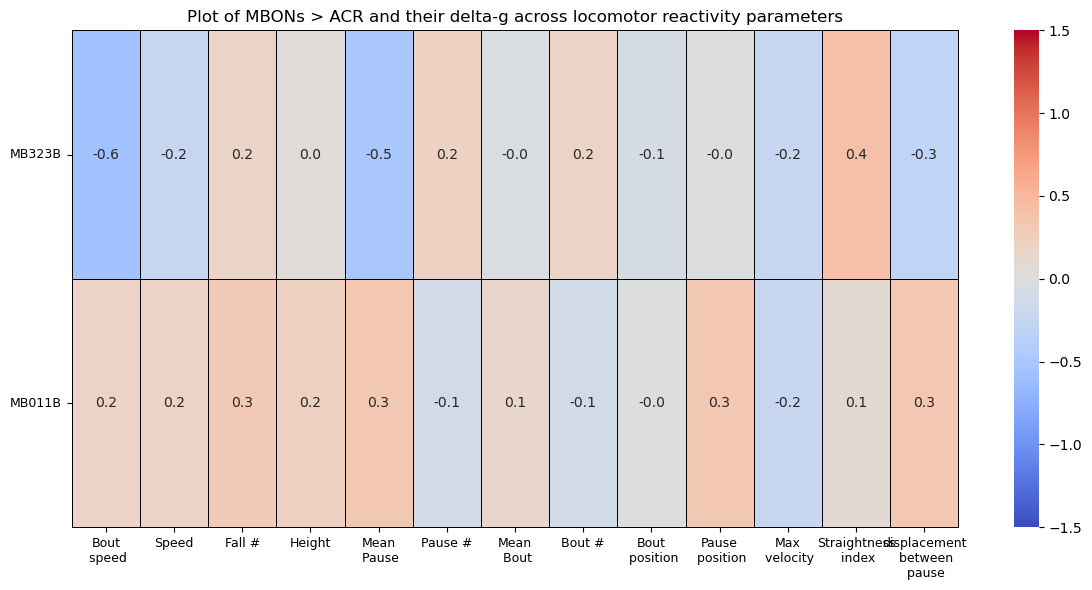

In [156]:
df5 = dfreg2.set_index(['MBON'])
fig, ax1 = plt.subplots(figsize=(12, 6))                
g1 = sns.heatmap(df5, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='coolwarm', linewidths=0.5, linecolor='black', clip_on=False)
g1.set_ylabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation = 0, fontsize = 9)
g1.set_xticklabels(g1.get_xticklabels(), rotation = 0, fontsize = 9)
ax1.set_title('Plot of MBONs > ' + responder + ' and their delta-g across locomotor reactivity parameters')
fig.tight_layout()
#plt.savefig(savelocation + "deltagheatmap_" + responder + "_" + date + ".png", dpi = 1200)

In [157]:
#delta and delta g heatmap
# 
dfreglist = [dfreg_bspeed, dfreg_speed, dfreg_fall,dfreg_height, dfreg_meanpause, dfreg_pause,dfreg_meanbout, dfreg_bout,dfreg_boutpos, dfreg_pausepos,dfreg_maxvelocity,dfreg_straightindex, dfreg_displacementbetweenpause]
totalregdf = pd.DataFrame()

for n,k in zip(dfreg2.columns, dfreglist):
    k.columns = pd.MultiIndex.from_product([[n], k.columns.tolist()])
    totalregdf = pd.concat([totalregdf, k], axis =1)

totalregdf

Bout\n speed                 Speed                Fall #         \
                 WT   Expt delta_g     WT   Expt delta_g     WT   Expt   
MBON                                                                     
MB011B       -0.156  0.173   0.193 -0.114  0.685   0.183 -0.178  0.194   
MB323B        0.318 -0.233  -0.567  0.417  0.141  -0.241 -0.303 -0.428   

               Height  ... Pause\n position Max\n velocity                 \
       delta_g     WT  ...          delta_g             WT   Expt delta_g   
MBON                   ...                                                  
MB011B   0.325 -0.486  ...            0.338          1.546  2.099  -0.235   
MB323B   0.175 -0.282  ...           -0.008          0.857  0.547  -0.235   

       Straightness\n index                displacement\n between\n pause  \
                         WT   Expt delta_g                             WT   
MBON                                                                        
MB011B               -0.023  0.062   0.086                          0.153   
MB323B                0.038  0.361   0.420                          0.422   

                       
         Expt delta_g  
MBON                   
MB011B  0.545   0.343  
MB323B  0.105  -0.297  

[2 rows x 39 columns]

In [196]:
# f1,ax = plt.subplots(nrows=1, ncols=13, sharex=False, sharey = True, figsize=(15, 6))

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

subplottitles = list(map(lambda s:s.replace('\n', ''), dfreg2.columns))
g1 = round(totalregdf,1)

fig = make_subplots(rows = 1,cols = 13, horizontal_spacing = 0.015, shared_yaxes =True, subplot_titles= dfreg2.columns)   


for n, j in zip(dfreg2.columns, list(range(1,14))):
    figure1 = px.imshow(g1[n], text_auto = True, aspect = "auto")
    fig.add_trace(figure1['data'][0], row = 1, col = j)

fig.update_layout(title = 'Plot of MBONs > <b>' + responder +  '</b> and their cohens d, delta-g across locomotor reactivity parameters', height = 400, width = 1800)
fig.update_annotations(font_size=12, yshift = -280)



fig.show()